In [1]:
import pandas as pd
import numpy as np
#import config as cfg
#import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold
from xgboost import XGBRegressor
from xgboost import plot_importance
import datetime as dt

from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

## 1. Product Clicks

In [2]:
df_clicks =  pd.read_csv("Tables/prod_product_viewed.csv")

In [3]:
df_clicks = df_clicks[['id', 'brand', 'category', 'event', 'event_text', 'name', 'original_timestamp', 'timestamp',\
                       'price', 'f0_', 'price']]
df_clicks.rename(columns={'f0_': 'product_id'}, inplace=True)

df_clicks

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,price
0,ajs-next-fb31736eeff5cf0a9bd64c5e43fb36e4,Colorbar,Womens Body Mist & Sprays,product_viewed,Product Viewed,ColorBar Face & Body Refreshing Rose Mist - 00...,2022-11-04 08:59:49 UTC,2022-11-04 08:59:49.925 UTC,595.0,7506852.0,595.0
1,ajs-next-597d90c63455e7c351026c75acc2efd3,Amazon Series,Hair Mask,product_viewed,Product Viewed,Amazon Series Jojoba Daily Moisturizing Kerati...,2023-04-05 04:42:45.008 UTC,2023-04-05 04:42:45.648 UTC,1530.0,7533631.0,1530.0
2,ajs-next-ea1343ea1b399c2874953f1f1811578c,Re'equil,Hair Mask,product_viewed,Product Viewed,Re'equil Pea Protein & Ceramide Hair Mask (200g),2023-04-05 06:31:29.076 UTC,2023-04-05 06:31:29.239 UTC,741.0,7520641.0,741.0
3,ajs-next-d7270287719b7576696f7303123883d5,K18,Hair Masks,product_viewed,Product Viewed,K18 Leave-In Molecular Repair Hair Mask (50ml),2023-04-05 06:02:26.298 UTC,2023-04-05 06:02:26.453 UTC,5625.0,7542322.0,5625.0
4,ajs-next-164fc4c41e70e721d8f282941b6ed862,VGR,Trimmers,product_viewed,Product Viewed,VGR V-683 Trimmer 200 min Runtime 4 Length Set...,2023-02-17 03:14:59.482 UTC,2023-02-17 03:14:59.727 UTC,2999.0,7539543.0,2999.0
...,...,...,...,...,...,...,...,...,...,...,...
191387,C1C5ACCC-1CC6-4233-8ED5-686620AADF6C,AND,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,And Eternal Radiance EDP & Ethereal Dreamer ED...,2023-01-20 07:09:40.26 UTC,2023-01-20 07:09:40.494 UTC,1428.0,7539779.0,1428.0
191388,15B79289-9C39-4F55-9558-A4A72447F359,Boss,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Boss The Scent Private Accord For Her Eau De P...,2023-01-26 19:03:03.535 UTC,2023-01-26 19:03:04.006 UTC,8000.0,7506670.0,8000.0
191389,BAF1F886-0280-4861-9826-59F265DAD903,Paco Rabanne,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Paco Rabanne Pure XS for Her Eau De Parfum (50ml),2023-02-13 17:28:53.317 UTC,2023-02-13 17:28:53.563 UTC,5270.0,7506583.0,5270.0
191390,3a3f1f8e-d6e1-401b-a142-f165ad2be7dd,Carolina Herrera,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Carolina Herrera Very Good Girl Eau De Parfum ...,2023-02-15 06:04:54.94 UTC,2023-02-15 06:04:56.617 UTC,8000.0,7506000.0,8000.0


In [4]:
df_clicks['original_timestamp'] = df_clicks['original_timestamp'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])
df_clicks['timestamp'] = df_clicks['timestamp'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])

df_clicks['timestamp'] = pd.to_datetime(df_clicks['timestamp'], format="%Y-%m-%d %H:%M:%S")
df_clicks['original_timestamp'] = pd.to_datetime(df_clicks['original_timestamp'], format="%Y-%m-%d %H:%M:%S")
df_clicks

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,price
0,ajs-next-fb31736eeff5cf0a9bd64c5e43fb36e4,Colorbar,Womens Body Mist & Sprays,product_viewed,Product Viewed,ColorBar Face & Body Refreshing Rose Mist - 00...,2022-11-04 08:59:49.000,2022-11-04 08:59:49.925,595.0,7506852.0,595.0
1,ajs-next-597d90c63455e7c351026c75acc2efd3,Amazon Series,Hair Mask,product_viewed,Product Viewed,Amazon Series Jojoba Daily Moisturizing Kerati...,2023-04-05 04:42:45.008,2023-04-05 04:42:45.648,1530.0,7533631.0,1530.0
2,ajs-next-ea1343ea1b399c2874953f1f1811578c,Re'equil,Hair Mask,product_viewed,Product Viewed,Re'equil Pea Protein & Ceramide Hair Mask (200g),2023-04-05 06:31:29.076,2023-04-05 06:31:29.239,741.0,7520641.0,741.0
3,ajs-next-d7270287719b7576696f7303123883d5,K18,Hair Masks,product_viewed,Product Viewed,K18 Leave-In Molecular Repair Hair Mask (50ml),2023-04-05 06:02:26.298,2023-04-05 06:02:26.453,5625.0,7542322.0,5625.0
4,ajs-next-164fc4c41e70e721d8f282941b6ed862,VGR,Trimmers,product_viewed,Product Viewed,VGR V-683 Trimmer 200 min Runtime 4 Length Set...,2023-02-17 03:14:59.482,2023-02-17 03:14:59.727,2999.0,7539543.0,2999.0
...,...,...,...,...,...,...,...,...,...,...,...
191387,C1C5ACCC-1CC6-4233-8ED5-686620AADF6C,AND,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,And Eternal Radiance EDP & Ethereal Dreamer ED...,2023-01-20 07:09:40.260,2023-01-20 07:09:40.494,1428.0,7539779.0,1428.0
191388,15B79289-9C39-4F55-9558-A4A72447F359,Boss,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Boss The Scent Private Accord For Her Eau De P...,2023-01-26 19:03:03.535,2023-01-26 19:03:04.006,8000.0,7506670.0,8000.0
191389,BAF1F886-0280-4861-9826-59F265DAD903,Paco Rabanne,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Paco Rabanne Pure XS for Her Eau De Parfum (50ml),2023-02-13 17:28:53.317,2023-02-13 17:28:53.563,5270.0,7506583.0,5270.0
191390,3a3f1f8e-d6e1-401b-a142-f165ad2be7dd,Carolina Herrera,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Carolina Herrera Very Good Girl Eau De Parfum ...,2023-02-15 06:04:54.940,2023-02-15 06:04:56.617,8000.0,7506000.0,8000.0


## Recency Bias

In [5]:
def recency_weight(timestamp, current_time, inverse_decay_rate=1):
    """
    Calculate recency weight for a given timestamp.
    
    Args:
        timestamp (datetime.datetime): The timestamp of the event.
        current_time (datetime.datetime): The current time or reference time.
        inverse_decay_rate (float): The decay rate for the time decay function. Must be greater than 0.5. Defaults to 1.
        inverse_decay_rate range: The higher the decay rate, the less the rate of decay and thus a narrow range of weights. The smaller the decay rate, the higher the rate of decay and thus a wider range of weights.
        Example: Highest decay rate can be obtained by setting inverse_decay_rate to 0.51. This gives exhorbitantly high weights to recently added products and very small weights to older products.

    Returns:
        float: The recency weight of the event.
    """
    time_difference = current_time - timestamp
    time_difference_in_days = time_difference.days
    if time_difference_in_days == 0:
        weight = 1  # Assign a maximum weight for events occurring on the same day
    else:
        weight = 1/np.log(inverse_decay_rate * time_difference_in_days)
    return weight

current_time = dt.datetime.now()

# Calculate recency weights for each event
df_clicks['recency_weight'] = df_clicks['original_timestamp'].apply(lambda x: recency_weight(x, current_time, inverse_decay_rate=1.3))


In [6]:
df_clicks.sort_values('original_timestamp', ascending=False )#[df_clicks_test['original_timestamp'] < '2023-01-01']

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,price,recency_weight
63556,4FCA5503-77AE-4A0B-9310-2B641B1FF405,Bobbi Brown,Lip Balm,product_viewed,Product Viewed,Bobbi Brown Extra Lip Tint - Bare Blackberry (...,2023-04-10 04:04:01.163,2023-04-10 04:04:01.628,2750.0,7541147.0,2750.0,0.734767
62504,4E62A6E4-C10A-4ECF-B872-BFE4D78B6660,Bobbi Brown,Lip Balm,product_viewed,Product Viewed,Bobbi Brown Extra Lip Tint - Bare Nude (2.3g),2023-04-10 04:03:56.932,2023-04-10 04:03:57.074,2750.0,7501877.0,2750.0,0.734767
29175,316F80D2-3000-44F9-82CB-9F81D94BA3D2,CLINIQUE,Gift Sets,product_viewed,Product Viewed,Clinique Merry Moisture (2Pcs),2023-04-10 04:03:22.760,2023-04-10 04:03:23.284,4050.0,7540042.0,4050.0,0.734767
160231,3C9A5260-A88F-4E50-BFA0-5669B5F05B0D,Lakme,Liquid Lipstick,product_viewed,Product Viewed,Lakme Absolute Matte Melt Mini Liquid Lip Colo...,2023-04-10 04:02:44.661,2023-04-10 04:02:45.404,268.0,7539215.0,268.0,0.734767
104604,D9694965-C55A-4CFB-80C6-6E855D03626F,L'Oreal Paris,Foundation,product_viewed,Product Viewed,L'Oreal Paris Infallible 32H Fresh Wear Founda...,2023-04-10 04:00:39.385,2023-04-10 04:00:39.547,999.0,7502655.0,999.0,0.734767
...,...,...,...,...,...,...,...,...,...,...,...,...
33384,ajs-next-716ff4d45f991b7d10ca8587bdccc0d5,NaN,NaN,product_viewed,Product Viewed,NaN,2022-07-21 15:52:38.576,2022-07-21 15:52:40.514,NaN,NaN,NaN,0.171171
32955,ajs-next-6f8fc942eb77ec01b059f1ca87b6507d,NaN,NaN,product_viewed,Product Viewed,NaN,2022-07-21 15:52:34.351,2022-07-21 15:52:36.061,NaN,NaN,NaN,0.171171
33348,ajs-next-798910d92eae4df5d0cc44132959401e,NaN,NaN,product_viewed,Product Viewed,NaN,2022-07-21 15:52:34.347,2022-07-21 15:52:35.993,NaN,NaN,NaN,0.171171
33349,ajs-next-0e540ced021c042aa66dfa9425ce31fd,NaN,NaN,product_viewed,Product Viewed,NaN,2022-07-21 15:52:34.343,2022-07-21 15:52:35.802,NaN,NaN,NaN,0.171171


## Brand-wise Clicks

In [7]:
df_clicks_brand = df_clicks.copy()
df_clicks_brand['brand'].value_counts()

Maybelline New York    13654
M.A.C                  13419
Lakme                  10410
Colorbar                9563
Estee Lauder            8405
                       ...  
Ivenross                   1
Chaitanya's                1
Pielor                     1
S-Shield                   1
Dorall Collection          1
Name: brand, Length: 728, dtype: int64

In [8]:
df_clicks_brand['clicks'] = np.zeros(len(df_clicks_brand))
df_clicks_brand = df_clicks_brand.groupby('brand', as_index=False).agg({'clicks': 'count', 'recency_weight': 'sum'})
df_clicks_brand['weighted_clicks'] = df_clicks_brand['clicks'] * df_clicks_brand['recency_weight']
df_clicks_brand.sort_values('clicks', ascending=False)

,brand,clicks,recency_weight,weighted_clicks
428,Maybelline New York,13654,4893.148900,6.681106e+07
404,M.A.C,13419,4454.192326,5.977081e+07
376,Lakme,10410,3400.976957,3.540417e+07
153,Colorbar,9563,2403.271412,2.298248e+07
213,Estee Lauder,8405,2362.339248,1.985546e+07
...,...,...,...,...
135,Chaitanya's,1,0.238425,2.384251e-01
596,Seyal Naturals,1,0.534244,5.342445e-01
573,S-Shield,1,0.606554,6.065537e-01
277,Hamam,1,0.231331,2.313312e-01


In [9]:
df_clicks_brand_recency = df_clicks_brand[['brand', 'weighted_clicks']].copy()

## Category-wise Clicks

In [10]:
brand_to_category_dict = dict(zip(df_clicks['brand'], df_clicks['category']))
brand_to_category_dict

{'Colorbar': 'Body Wash & Shower Gel',
 'Amazon Series': 'Conditioner',
 "Re'equil": 'Serums & Essences',
 'K18': 'Hair Mask',
 'VGR': 'Trimmers',
 'Bobbi Brown': 'Face Moisturizer',
 'VI-JOHN': 'Aftershave Lotion',
 'Mancode': 'Serums & Essence',
 'Innisfree': 'Serums & Essences',
 'Wella Professionals': 'Conditioner',
 'GlowGlutathione': 'Multivitamins',
 'India Grooming Club': 'Mens Perfumes (EDT & EDP)',
 'Insight Cosmetics': 'Liquid Lipstick',
 'Dermalogica': 'Serums & Essences',
 'Vaseline': 'Body Wash & Shower Gel',
 'Estee Lauder': 'Womens Perfumes (EDT & EDP)',
 'Maybelline New York': 'Liquid Lipstick',
 '23 Yards': 'Hand Wash',
 'The Pink Foundry': 'Serums & Essences',
 'Mamaearth': 'Womens Perfumes (EDT & EDP)',
 'FOGG': 'Womens Perfumes (EDT & EDP)',
 'Blue Heaven': 'Liquid Lipstick',
 'RENEE': 'Liquid Lipstick',
 'KAMA Ayurveda': 'Body Wash & Shower Gel',
 'Lakme': 'Serums & Essences',
 'The Face Shop': 'Body Wash & Shower Gel',
 'Anastasia Beverly Hills': 'Liquid Lipstick

In [11]:
len(brand_to_category_dict.keys())

729

In [12]:
df_clicks_category = df_clicks.copy()
df_clicks_category['clicks'] = np.zeros(len(df_clicks_category))
df_clicks_category = df_clicks_category.groupby('category', as_index=False).agg({'clicks': 'count', 'recency_weight': 'sum'})
df_clicks_category['weighted_clicks'] = df_clicks_category['clicks'] * df_clicks_category['recency_weight']
df_clicks_category.sort_values('clicks', ascending=False)

,category,clicks,recency_weight,weighted_clicks
137,Lipstick,21594,6965.958041,1.504229e+08
92,Foundation,18165,5124.090118,9.307910e+07
138,Liquid Lipstick,15884,5777.462681,9.176922e+07
165,Nail Polish,7277,2551.204842,1.856512e+07
48,Concealer,6232,1991.528255,1.241120e+07
...,...,...,...,...
44,Butter,1,0.192963,1.929628e-01
200,Stretch Mark Creams & Oil,1,0.231331,2.313312e-01
142,Lotions & Creams,1,0.176242,1.762422e-01
177,Salted Biscuits,1,0.192963,1.929628e-01


In [13]:
df_clicks_category_recency = df_clicks_category[['category', 'weighted_clicks']].copy()

## 2. Order Completed

In [14]:
df_order_completed = pd.read_csv("Tables/prod_order_completed.csv")
df_order_completed = df_order_completed[df_order_completed['products'].isnull() == False]


df_order_completed['original_timestamp'] = df_order_completed['original_timestamp'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])
df_order_completed['timestamp'] = df_order_completed['timestamp'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])

df_order_completed['timestamp'] = pd.to_datetime(df_order_completed['timestamp'], format="%Y-%m-%d %H:%M:%S")
df_order_completed['original_timestamp'] = pd.to_datetime(df_order_completed['original_timestamp'], format="%Y-%m-%d %H:%M:%S")
df_order_completed.sort_values('original_timestamp', ascending=False)

,id,event,event_text,original_timestamp,timestamp,products
3415,D66E12FC-5738-4743-A59C-12689F7E29F1,order_completed,Order Completed,2023-04-10 04:52:30.835,2023-04-10 04:52:30.982,"[{""brand"":""M.A.C"",""category"":""Face Primer"",""co..."
54,49e1895a-706c-4c51-964b-f50b01743e27,order_completed,Order Completed,2023-04-10 03:20:04.298,2023-04-10 03:20:04.612,"[{""brand"":""SUGAR Cosmetics"",""category"":""Loose ..."
440,ajs-next-3c64ff8d3d744f2f29b8201ea8a2320c,order_completed,Order Completed,2023-04-10 02:56:22.337,2023-04-10 02:56:22.492,"[{""brand"":""The Derma Co"",""category"":""Serums \u..."
1993,81FCCDF4-5AFE-4CCD-A879-1FB5EED369E1,order_completed,Order Completed,2023-04-10 02:54:37.352,2023-04-10 02:54:37.853,"[{""brand"":""Bioderma"",""category"":""Skin Cleanser..."
1562,ajs-next-bc08df1ad763f33b1ba5b3c7068b70be,order_completed,Order Completed,2023-04-10 02:54:30.033,2023-04-10 02:54:28.476,"[{""brand"":""The Man Company"",""category"":""Hair S..."
...,...,...,...,...,...,...
2838,ajs-next-0394f64a17821198ce9e8a1a06b42055,order_completed,Order Completed,2022-07-22 09:20:16.812,2022-07-22 09:20:17.132,"[{""item_brand"":""Colorbar"",""item_id"":7500030,""i..."
3569,ajs-next-ccd84dc6ac13c58e372fc4b5874b0a15,order_completed,Order Completed,2022-07-22 07:47:53.189,2022-07-22 07:47:53.457,"[{""item_brand"":""Colorbar"",""item_id"":7500030,""i..."
2649,ajs-next-4016afced2ca84ef70ec9c71af446244,order_completed,Order Completed,2022-07-22 03:57:28.037,2022-07-22 03:57:28.675,"[{""item_brand"":""Colorbar"",""item_id"":7500062,""i..."
255,ajs-next-fb68b38d572ae697ff26fc0da9949fc3,order_completed,Order Completed,2022-07-21 17:05:39.695,2022-07-21 17:05:39.923,"[{""item_brand"":""Colorbar"",""item_id"":7500049,""i..."


In [15]:
df_order_completed = pd.concat([pd.DataFrame(eval(x)) for x in df_order_completed['products']], \
                               keys=df_order_completed['original_timestamp']).reset_index(level=1, drop=True).reset_index()
df_order_completed

,original_timestamp,brand,name,price,product_id,quantity,item_brand,item_id,item_name,category,coupon,currency,category_id,image_url,size,item_price,item_quantity
0,2023-03-19 20:10:06.213,SUGAR Cosmetics,Sugar All Set To Go Banana Loose Powder - Beig...,599.0,7502478,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-03-05 06:19:42.092,PAC,PAC Eyeliner Brush - 372 (1Pc),345.0,7541854,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-03-05 06:19:42.092,CLINIQUE,Clinique Moisture Surge 100H Auto-Replenishing...,4100.0,7543048,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-03-05 06:19:42.092,CLINIQUE,GWP CLINIQUE High Impact Mascara - Deluxe Samp...,0.0,7546267,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-02-22 14:16:32.534,COSRX,COSRX Low pH Good Morning Gel Cleanser (150ml),765.0,7524037,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,2023-01-09 12:07:23.722,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN
8918,2023-01-09 12:04:21.281,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN
8919,2023-01-09 12:03:51.681,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN
8920,2023-01-07 17:05:24.484,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN


In [16]:
df_order_completed = df_order_completed.fillna('0')
for i, row in df_order_completed.iterrows():
    if (row['brand'] == '0'):
        row['brand'] = row['item_brand']
    if (row['name'] == '0'):
        row['name'] = row['item_name']
    if (row['product_id'] == '0'):
        row['product_id'] = row['item_id']
    if (row['category'] == '0'):
        if (row['brand'] in brand_to_category_dict.keys()):
            row['category'] = brand_to_category_dict[row['brand']]
    if (row['price'] == '0'):
        row['price'] = row['item_price']
    if (row['quantity'] == '0'):
        row['quantity'] = row['item_quantity']

In [17]:
df_order_completed['price'] = df_order_completed['price'].astype(float)
df_order_completed['quantity'] = df_order_completed['quantity'].astype(float)

df_order_completed['quantity'] = df_order_completed['quantity'].apply(lambda x: 1 if x == 0 else x)
df_order_completed['category'] = df_order_completed['category'].apply(lambda x: 'not set' if x == '0' else x)
df_order_completed.sort_values('original_timestamp', ascending=False)

,original_timestamp,brand,name,price,product_id,quantity,item_brand,item_id,item_name,category,coupon,currency,category_id,image_url,size,item_price,item_quantity
7787,2023-04-10 04:52:30.835,M.A.C,M.A.C Prep + Prime Fix+ - Original (100ml),1950.0,7519188,1.0,0,0,0,Face Primer,TIRA20 coupon applied,INR,0,0,0,0,0
7792,2023-04-10 04:52:30.835,Lakme,Lakme Cushion Matte Lipstick - Pink Ruby (4.5g),299.0,7547092,1.0,0,0,0,Lipstick,TIRA20 coupon applied,INR,0,0,0,0,0
7791,2023-04-10 04:52:30.835,Biolage,Biolage 6-In-1 Smoothproof Deep Smoothening Se...,325.0,7555467,1.0,0,0,0,Hair Serum,TIRA20 coupon applied,INR,0,0,0,0,0
7790,2023-04-10 04:52:30.835,Tresemme,Tresemme Keratin Smooth Deep Smoothing Mask - ...,510.0,7528546,1.0,0,0,0,Hair Mask,TIRA20 coupon applied,INR,0,0,0,0,0
7789,2023-04-10 04:52:30.835,Babila,Babila Eye Blending Brush MB-V023,110.0,7546076,1.0,0,0,0,Eye Brush,TIRA20 coupon applied,INR,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6498,2022-07-22 09:20:16.812,0,0,0.0,0,1.0,Colorbar,7500030.0,Colorbar 24Hrs Weightless Liquid Foundation - ...,not set,0,0,0,0,0,0,0
8184,2022-07-22 07:47:53.189,0,0,0.0,0,1.0,Colorbar,7500030.0,Colorbar 24Hrs Weightless Liquid Foundation - ...,not set,0,0,0,0,0,0,0
6106,2022-07-22 03:57:28.037,0,0,0.0,0,1.0,Colorbar,7500062.0,Colorbar Skin Perfect SPF 60 Liquid Foundation...,not set,0,0,0,0,0,0,0
551,2022-07-21 17:05:39.695,0,0,0.0,0,1.0,Colorbar,7500049.0,Colorbar Aquafeel Tube Foundation - 006 Carame...,not set,0,0,0,0,0,0,0


In [18]:
df_order_completed.drop(['item_brand', 'item_name', 'item_id', 'item_price', 'item_quantity', 'category_id', 'image_url', 'coupon', 'size', 'currency'], axis=1, inplace=True)

In [19]:
df_order_completed['recency_weight'] = df_order_completed['original_timestamp'].apply(lambda x: recency_weight(x, current_time, inverse_decay_rate=1.3))
df_order_completed.sort_values('original_timestamp', ascending=False)

,original_timestamp,brand,name,price,product_id,quantity,category,recency_weight
7787,2023-04-10 04:52:30.835,M.A.C,M.A.C Prep + Prime Fix+ - Original (100ml),1950.0,7519188,1.0,Face Primer,0.734767
7792,2023-04-10 04:52:30.835,Lakme,Lakme Cushion Matte Lipstick - Pink Ruby (4.5g),299.0,7547092,1.0,Lipstick,0.734767
7791,2023-04-10 04:52:30.835,Biolage,Biolage 6-In-1 Smoothproof Deep Smoothening Se...,325.0,7555467,1.0,Hair Serum,0.734767
7790,2023-04-10 04:52:30.835,Tresemme,Tresemme Keratin Smooth Deep Smoothing Mask - ...,510.0,7528546,1.0,Hair Mask,0.734767
7789,2023-04-10 04:52:30.835,Babila,Babila Eye Blending Brush MB-V023,110.0,7546076,1.0,Eye Brush,0.734767
...,...,...,...,...,...,...,...,...
6498,2022-07-22 09:20:16.812,0,0,0.0,0,1.0,not set,0.171171
8184,2022-07-22 07:47:53.189,0,0,0.0,0,1.0,not set,0.171171
6106,2022-07-22 03:57:28.037,0,0,0.0,0,1.0,not set,0.171171
551,2022-07-21 17:05:39.695,0,0,0.0,0,1.0,not set,0.171171


## Brand-wise

In [20]:
df_order_completed_brand = df_order_completed.copy()

In [21]:
df_order_completed_brand['no_of_unique_purchases'] = np.zeros(len(df_order_completed_brand))

df_grouped = df_order_completed_brand.groupby('brand', as_index=False).agg({'price':'sum', 'quantity':'sum', 'recency_weight':'sum', 'no_of_unique_purchases': 'count'})
df_grouped.rename(columns={'quantity':'no_of_purchases'}, inplace=True)
df_grouped.sort_values(by='no_of_unique_purchases', ascending=False, inplace=True)
df_grouped['weighted_unique_purchases'] = df_grouped['no_of_unique_purchases'] * df_grouped['recency_weight']
df_grouped['weighted_purchases'] = df_grouped['no_of_purchases'] * df_grouped['recency_weight']

df_grouped.sort_values(by='no_of_unique_purchases', ascending=False)

,brand,price,no_of_purchases,recency_weight,no_of_unique_purchases,weighted_unique_purchases,weighted_purchases
216,Lakme,136454.54,526.0,141.012750,466,65711.941351,74172.706332
264,Minimalist,159653.67,343.0,107.858520,319,34406.867998,36995.472486
257,Maybelline New York,140812.45,345.0,96.639040,309,29861.463224,33340.468648
321,Plum,112691.35,334.0,98.559193,299,29469.198648,32918.770396
0,0,0.00,246.0,43.281724,246,10647.304091,10647.304091
...,...,...,...,...,...,...,...
406,Toni&Guy,636.75,1.0,0.244439,1,0.244439,0.244439
394,The Beauty Sailor,1249.00,1.0,0.203013,1,0.203013,0.203013
70,BrownSkin Beauty,499.00,1.0,0.261937,1,0.261937,0.261937
90,Coach,3900.00,1.0,0.606554,1,0.606554,0.606554


In [22]:
df_order_completed_brand = df_grouped.copy()

## Category-wise

In [23]:
df_order_completed_category = df_order_completed.copy()

In [24]:
df_order_completed_category['no_of_unique_purchases'] = np.zeros(len(df_order_completed_category))

df_grouped = df_order_completed_category.groupby('category', as_index=False).agg({'price':'sum', 'quantity':'sum', 'no_of_unique_purchases': 'count', 'recency_weight':'sum'})
df_grouped.rename(columns={'quantity':'no_of_purchases'}, inplace=True)
df_grouped.sort_values(by='no_of_unique_purchases', ascending=False, inplace=True)
df_grouped['weighted_unique_purchases'] = df_grouped['no_of_unique_purchases'] * df_grouped['recency_weight']

df_grouped

,category,price,no_of_purchases,no_of_unique_purchases,recency_weight,weighted_unique_purchases
170,not set,2074156.70,4583.0,4011,1020.411006,4.092869e+06
157,Soaps,20890.14,410.0,276,79.427264,2.192192e+04
147,Shampoo,110392.95,310.0,264,108.994158,2.877446e+04
112,Lipstick,193759.30,296.0,234,83.199940,1.946879e+04
59,Face Moisturiser,240499.20,250.0,211,86.923732,1.834091e+04
...,...,...,...,...,...,...
104,Lip Brush,445.00,1.0,1,0.486826,4.868256e-01
137,Nail Polish Sets,2500.00,1.0,1,0.323041,3.230415e-01
114,Loofahs & Sponges,375.00,1.0,1,0.215898,2.158982e-01
118,Makeup Pouches,1700.00,1.0,1,0.323041,3.230415e-01


In [25]:
df_order_completed_category = df_grouped.copy()

## 3. Adds to Wishlist From Cart

In [26]:
df_wishlist = pd.read_csv('Tables/prod_adds_to_wishlist.csv')

In [27]:
df_wishlist['original_timestamp'] = df_wishlist['original_timestamp'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])
df_wishlist['timestamp'] = df_wishlist['timestamp'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])

df_wishlist['timestamp'] = pd.to_datetime(df_wishlist['timestamp'], format="%Y-%m-%d %H:%M:%S")
df_wishlist['original_timestamp'] = pd.to_datetime(df_wishlist['original_timestamp'], format="%Y-%m-%d %H:%M:%S")
df_wishlist

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,quantity
0,ajs-next-015b7af6596d763141f3d46941181c03,Colorbar,Hand Creams,product_added_to_wishlist,Product Added to Wishlist,Colorbar Toast To Tahiti Fruit Drop Hand Cream...,2022-08-18 04:49:25.199,2022-08-18 04:49:25.534,275.0,7504904.0,1.0
1,ajs-next-3c228cfd2f01ea106b9334a279c7ad2b,India Grooming Club,Shavers,product_added_to_wishlist,Product Added to Wishlist,India Grooming Club Black Shaving Razor Handle...,2023-03-06 03:03:23.175,2023-03-06 03:03:23.144,16000.0,7521080.0,1.0
2,ajs-next-6f9ab2addfcee447d343fca05b7e8f1f,Vega,Mani-Pedi Tools & Kits,product_added_to_wishlist,Product Added to Wishlist,"set of Foot care, (PM-03)",2023-03-06 07:43:28.600,2023-03-06 07:43:28.605,NaN,7513281.0,1.0
3,ajs-next-64cd4a9906319b038a2cb26402866a2a,Gillette,Razors & Cartridges,product_added_to_wishlist,Product Added to Wishlist,Gillette Mach 3 Turbo Manual Shaving Razor Bla...,2023-02-25 11:07:47.504,2023-02-25 11:07:48.719,NaN,7547314.0,1.0
4,ajs-next-11fc7950c2e75f7c009cb6b57be395fb,L'Oreal Paris,Hair Colour,product_added_to_wishlist,Product Added to Wishlist,"L'Oreal Paris Casting Creme Gloss Hair Color, ...",2023-02-26 17:54:36.813,2023-02-26 17:54:37.215,NaN,7500061.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
17386,8DD2C8BF-02B3-4FC7-A316-80FBD1C20096,Dove,Womens Deodorants & Roll-Ons,product_added_to_wishlist,Product Added to Wishlist,Dove Original Deodorant Roll On (50ml),2023-02-02 05:36:59.426,2023-02-02 05:36:59.610,220.0,7537511.0,1.0
17387,ajs-next-cf9f70a38cfee45eb521566714b65b7d,Antonio Banderas,Womens Deodorants & Roll-Ons,product_added_to_wishlist,Product Added to Wishlist,Antonio Banderas Blue Seduction for Women Deod...,2023-01-20 09:35:11.579,2023-01-20 09:35:12.191,NaN,7506565.0,1.0
17388,EE89C4EF-8BF7-4984-9851-BD2A9B638C0F,Ajmal,Womens Deodorants & Roll-Ons,product_added_to_wishlist,Product Added to Wishlist,Ajmal Shadow Homme & Sacred Love Deodorant Spr...,2023-02-16 16:29:36.695,2023-02-16 16:29:37.063,327.0,7516334.0,1.0
17389,ajs-next-f227259e9202a58c277f5b1d293768e4,Nivea,Womens Deodorants & Roll-Ons,product_added_to_wishlist,Product Added to Wishlist,Nivea Women Fresh Natural Deodorant Roll On (5...,2023-02-13 09:19:44.375,2023-02-13 09:19:44.676,172.0,7516982.0,1.0


In [28]:
df_wishlist['recency_weight'] = df_wishlist['original_timestamp'].apply(lambda x: recency_weight(x, current_time, inverse_decay_rate=1.3))

In [29]:
df_wishlist.sort_values('original_timestamp', ascending=False )#[df_clicks_test['original_timestamp'] < '2023-01-01']

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,quantity,recency_weight
3209,41590D9F-13FD-44EF-971C-8B38B148FAC2,CLINIQUE,Pre & Post Shaves,product_added_to_wishlist,Product Added to Wishlist,Clinique For Men Aloe Shave Gel (125ml),2023-03-23 04:56:13.648,2023-03-23 04:56:14.339,1900.0,7539928.0,1.0,0.302399
725,DD1841DD-3265-4B16-944B-78B3FCBDE529,AXE,Talc,product_added_to_wishlist,Product Added to Wishlist,AXE Signature Denim Cologne Talc (100g),2023-03-23 04:54:44.223,2023-03-23 04:54:44.812,78.0,7517666.0,1.0,0.302399
6614,903e4635-aae6-4c96-8519-23dcd2dc1023,Plum,Perfume,product_added_to_wishlist,Product Added to Wishlist,Plum Bodylovin Hawaiian Rumba Eau De Parfum - ...,2023-03-23 04:54:20.984,2023-03-23 04:54:22.068,950.0,7528220.0,1.0,0.302399
6442,99db7f1f-85b6-4fc0-b3b5-6ba03fa246d7,Maybelline New York,Mascara,product_added_to_wishlist,Product Added to Wishlist,Maybelline New York Lash Sensational Waterproo...,2023-03-23 04:51:22.132,2023-03-23 04:51:24.315,510.0,7540727.0,1.0,0.302399
2120,1AE12DD5-6505-44BF-92CE-8DC0BA50198B,Swiss Beauty,Eye Shadow,product_added_to_wishlist,Product Added to Wishlist,Swiss Beauty Ultimate Eye Shadow Palette - 05 ...,2023-03-23 04:44:44.622,2023-03-23 04:44:44.868,242.0,7542711.0,1.0,0.302399
...,...,...,...,...,...,...,...,...,...,...,...,...
4398,ajs-next-5334e2102e9ff693bf2cce411536eed2,NaN,NaN,product_added_to_wishlist,Product Added to Wishlist,NaN,2022-07-21 15:52:38.585,2022-07-21 15:52:41.198,NaN,NaN,NaN,0.171171
4041,ajs-next-f21b1a4466ccb9748739d88c63ab5837,NaN,NaN,product_added_to_wishlist,Product Added to Wishlist,NaN,2022-07-21 15:52:34.353,2022-07-21 15:52:36.101,NaN,NaN,NaN,0.171171
4598,ajs-next-b2533fabfe7b4946b71bdf5d6690a1b4,NaN,NaN,product_added_to_wishlist,Product Added to Wishlist,NaN,2022-07-21 15:52:34.349,2022-07-21 15:52:36.055,NaN,NaN,NaN,0.171171
5243,ajs-next-e155aaa215fc17c2337b5ad12c8933a1,NaN,NaN,product_added_to_wishlist,Product Added to Wishlist,NaN,2022-07-21 15:52:34.345,2022-07-21 15:52:35.875,NaN,NaN,NaN,0.171171


## Brand-wise

In [30]:
df_wishlist_brand = df_wishlist.copy()
df_wishlist_brand['no_of_adds_to_wishlist'] = np.zeros(len(df_wishlist_brand))
df_grouped = df_wishlist_brand.groupby('brand', as_index=False).agg({'no_of_adds_to_wishlist': 'count', 'recency_weight': 'sum'}).sort_values('no_of_adds_to_wishlist', ascending= False)
df_grouped['weighted_adds_to_wishlist'] = df_grouped['no_of_adds_to_wishlist'] * df_grouped['recency_weight']
df_grouped.sort_values(by='no_of_adds_to_wishlist', ascending=False, inplace=True)

In [31]:
df_grouped

,brand,no_of_adds_to_wishlist,recency_weight,weighted_adds_to_wishlist
110,Colorbar,1686,305.927999,515794.606797
271,M.A.C,893,211.347124,188732.981742
288,Maybelline New York,585,147.669388,86386.591779
149,Estee Lauder,505,123.129518,62180.406481
253,Lakme,480,124.484383,59752.503994
...,...,...,...,...
324,Numis Med,1,0.203801,0.203801
77,Bodyguard,1,0.234209,0.234209
71,Bioayurveda,1,0.248536,0.248536
254,Lanvin,1,0.263941,0.263941


In [32]:
df_wishlist_brand = df_grouped.copy()

## Category-wise

In [33]:
df_wishlist_category = df_wishlist.copy()

In [34]:
df_wishlist_category['no_of_adds_to_wishlist'] = np.zeros(len(df_wishlist_category))
df_grouped = df_wishlist_category.groupby('category', as_index=False).agg({'no_of_adds_to_wishlist': 'count', 'recency_weight': 'sum'}).sort_values('no_of_adds_to_wishlist', ascending= False)
df_grouped['weighted_adds_to_wishlist'] = df_grouped['no_of_adds_to_wishlist'] * df_grouped['recency_weight']
df_grouped

,category,no_of_adds_to_wishlist,recency_weight,weighted_adds_to_wishlist
92,Foundation,1628,317.745441,517289.577570
148,Lipstick,1135,261.622690,296941.752932
149,Liquid Lipstick,613,138.119166,84667.048685
170,Mens Perfumes (EDT & EDP),599,134.212172,80393.091119
51,Concealer,543,131.097439,71185.909388
...,...,...,...,...
211,Shower Gels and Body Wash,1,0.228664,0.228664
100,Glimmer,1,0.203013,0.203013
213,Skin Brightening,1,0.207180,0.207180
101,Grooming Kits,1,0.266037,0.266037


In [35]:
df_wishlist_category = df_grouped.copy()

## 4. Adds to Cart

In [36]:
df_cart = pd.read_csv('tables/prod_adds_to_cart.csv')
df_cart['original_timestamp'] = df_cart['original_timestamp'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])
df_cart['timestamp'] = df_cart['timestamp'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1])

df_cart['timestamp'] = pd.to_datetime(df_cart['timestamp'], format="%Y-%m-%d %H:%M:%S")
df_cart['original_timestamp'] = pd.to_datetime(df_cart['original_timestamp'], format="%Y-%m-%d %H:%M:%S")
df_cart

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,quantity
0,ajs-next-415c1a1b12b6a1446e186253ae8cdc19,SUGAR Cosmetics,Face Makeup Palettes,product_added,Product Added,Sugar Contour De Force Highlighter Palette - 0...,2022-08-16 14:58:56.690,2022-08-16 14:58:57.328,799.0,7501447.0,1.0
1,ajs-next-118db6a76344452f9a5526cb05fe29ff,Miss Claire,Lip Liner,product_added,Product Added,Miss Claire Glimmersticks Lipliner - L-13 Maro...,2023-02-23 16:45:32.466,2023-02-23 16:45:32.988,58.0,7503531.0,1.0
2,ajs-next-f7fbb744a2e1610bc9c13a0c8dc40d7b,Vega,Hair Combs,product_added,Product Added,"Set of 6 comb, (HCS-03)",2023-02-23 08:26:11.708,2023-02-23 08:26:11.741,280.0,7507866.0,1.0
3,ajs-next-d280035ee6e45211b2c7042945d9d2d1,Innisfree,BB & CC Creams,product_added,Product Added,Innisfree Simple Label Tinted Moisturizer 4 (T...,2023-02-23 16:24:59.958,2023-02-23 16:25:00.732,1370.0,7526419.0,1.0
4,ajs-next-06f62969f469d1b71f995a5ffc26c4dc,The Man Company,Moustache Oil,product_added,Product Added,The Man Company Moustache Growth Oil Roll-On (...,2023-01-16 08:19:08.985,2023-01-16 08:19:10.086,216.0,7533606.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
98429,de87db35-546e-4eb7-b09b-34ff3b8b3b0f,Vaseline,Body Lotions & Moisturisers,product_added,Product Added,Vaseline Intensive Care Deep Moisture Body Lot...,2023-04-04 17:43:18.058,2023-04-04 17:43:19.800,190.0,7527596.0,1.0
98430,7a3435a3-4356-4f86-9790-41839548d633,Plum,Body Lotions & Moisturisers,product_added,Product Added,Plum Bodylovin Hawaiian Rumba Colada Gel Lotio...,2023-03-17 09:12:21.196,2023-03-17 09:12:21.370,475.0,7527266.0,1.0
98431,F2670487-7E3E-44D4-B5B1-C503FAF45DEE,Vaseline,Body Lotions & Moisturisers,product_added,Product Added,Vaseline Calming Lavender Body Lotion - (400ml),2023-04-08 16:45:27.627,2023-04-08 16:45:28.103,449.0,7527289.0,1.0
98432,B6E9AB49-D809-4427-BEF8-E5C7C52D9D39,Suganda,Body Lotions & Moisturisers,product_added,Product Added,Suganda 5% Lactic Acid Body Lotion - (200ml),2023-04-04 03:23:51.530,2023-04-04 03:23:52.534,617.0,7527661.0,1.0


In [37]:
df_cart['recency_weight'] = df_cart['original_timestamp'].apply(lambda x: recency_weight(x, current_time, inverse_decay_rate=1.3))
df_cart.sort_values('original_timestamp', ascending=False )#[df_clicks_test['original_timestamp'] < '2023-01-01']

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,quantity,recency_weight
64436,e14d8c14-50e6-4a04-8007-fad12752543c,Bobbi Brown,Face Primer,product_added,Product Added,Bobbi Brown Vitamin Enriched Face Base - Beige...,2023-04-10 04:56:47.236,2023-04-10 04:56:48.874,2090.0,7502799.0,1.0,0.734767
64437,e6685896-73c6-4d2f-913f-0b5d6927a9ce,Bobbi Brown,Face Primer,product_added,Product Added,Bobbi Brown Vitamin Enriched Face Base - Beige...,2023-04-10 04:56:44.619,2023-04-10 04:56:46.240,2090.0,7502799.0,1.0,0.734767
64335,b64f1e72-2c4c-44a4-80a8-b6992cffd7de,Bobbi Brown,Face Primer,product_added,Product Added,Bobbi Brown Vitamin Enriched Face Base - Beige...,2023-04-10 04:56:43.762,2023-04-10 04:56:45.392,2090.0,7502799.0,1.0,0.734767
64336,c0c87198-5c74-45ff-8855-419f08c93b6d,Bobbi Brown,Face Primer,product_added,Product Added,Bobbi Brown Vitamin Enriched Face Base - Beige...,2023-04-10 04:56:40.733,2023-04-10 04:56:42.362,2090.0,7502799.0,1.0,0.734767
63325,be927505-394b-4553-9cda-3b1e25be13bc,Bobbi Brown,Face Primer,product_added,Product Added,Bobbi Brown Vitamin Enriched Face Base - Beige...,2023-04-10 04:56:33.801,2023-04-10 04:56:35.473,2090.0,7502799.0,1.0,0.734767
...,...,...,...,...,...,...,...,...,...,...,...,...
19394,ajs-next-f271bce8b88c2ffd81917457609dfe87,NaN,NaN,product_added,Product Added,NaN,2022-07-21 15:52:38.577,2022-07-21 15:52:40.915,NaN,NaN,NaN,0.171171
19124,ajs-next-84bf416b6b401075601da7267238fde4,NaN,NaN,product_added,Product Added,NaN,2022-07-21 15:52:34.352,2022-07-21 15:52:36.091,NaN,NaN,NaN,0.171171
19162,ajs-next-c4112eb0e06f155daffe206668637532,NaN,NaN,product_added,Product Added,NaN,2022-07-21 15:52:34.348,2022-07-21 15:52:35.986,NaN,NaN,NaN,0.171171
20029,ajs-next-782191e8ec92e875f6aef69540fd4771,NaN,NaN,product_added,Product Added,NaN,2022-07-21 15:52:34.344,2022-07-21 15:52:35.847,NaN,NaN,NaN,0.171171


## Brand-wise

In [38]:
df_cart_brand = df_cart.copy()
df_cart_brand['no_of_adds_to_cart'] = np.zeros(len(df_cart_brand))
df_cart_brand = df_cart_brand.groupby('brand', as_index=False).agg({'no_of_adds_to_cart': 'count', 'recency_weight': 'sum'})
df_cart_brand['weighted_adds_to_cart'] = df_cart_brand['no_of_adds_to_cart'] * df_cart_brand['recency_weight']
df_cart_brand.sort_values(by='no_of_adds_to_cart', ascending=False, inplace=True)
df_cart_brand

,brand,no_of_adds_to_cart,recency_weight,weighted_adds_to_cart
139,Colorbar,6448,1305.129242,8.415473e+06
365,M.A.C,5663,1667.442698,9.442728e+06
387,Maybelline New York,3550,1077.900617,3.826547e+06
340,Lakme,3180,1029.740482,3.274575e+06
479,Plum,3082,998.817134,3.078354e+06
...,...,...,...,...
261,IKWI,1,0.194073,1.940725e-01
539,Sebastian Professional,1,0.606554,6.065537e-01
282,It's Skin,1,0.302399,3.023992e-01
504,Rebloom,1,0.344659,3.446586e-01


## Category-wise

In [39]:
df_cart_category = df_cart.copy()
df_cart_category['no_of_adds_to_cart'] = np.zeros(len(df_cart_category))

df_cart_category = df_cart_category.groupby('category', as_index=False).agg({'no_of_adds_to_cart': 'count', 'recency_weight': 'sum'})
df_cart_category['weighted_adds_to_cart'] = df_cart_category['no_of_adds_to_cart'] * df_cart_category['recency_weight']
df_cart_category.sort_values(by='no_of_adds_to_cart', ascending=False, inplace=True)
df_cart_category

,category,no_of_adds_to_cart,recency_weight,weighted_adds_to_cart
89,Foundation,7290,1753.658252,1.278417e+07
134,Lipstick,6405,1856.077499,1.188818e+07
176,Shampoo,4342,1530.347793,6.644770e+06
174,Serums & Essences,3982,1339.646075,5.334471e+06
74,Face Moisturiser,3867,1360.287174,5.260231e+06
...,...,...,...,...
48,Condoms,2,0.405253,8.105053e-01
50,Cream Biscuits,1,0.192963,1.929628e-01
84,Firming Gels & Creams,1,0.202245,2.022451e-01
4,Anti-Cellulite Creams,1,0.306928,3.069277e-01


## Joining all tables

In [40]:
# Brand Tables
df_joined_brand = df_clicks_brand_recency.merge(df_order_completed_brand, on='brand', how='inner', suffixes=('', '_order_completes')).\
                            merge(df_wishlist_brand, on='brand', how='inner', suffixes=('', '_wishlist'))
df_joined_brand = df_joined_brand.merge(df_cart_brand, on='brand', how='inner', suffixes=('', '_cart'))
df_joined_brand

,brand,weighted_clicks,price,no_of_purchases,recency_weight,no_of_unique_purchases,weighted_unique_purchases,weighted_purchases,no_of_adds_to_wishlist,recency_weight_wishlist,weighted_adds_to_wishlist,no_of_adds_to_cart,recency_weight_cart,weighted_adds_to_cart
0,18.21 Man Made,9495.091482,2400.00,1.0,0.363998,1,0.363998,0.363998,53,11.089807,587.759778,156,34.294300,5349.910732
1,23 Yards,220.692465,598.00,29.0,0.818319,3,2.454957,23.731255,11,2.475107,27.226178,57,17.988593,1025.349809
2,A Fragrance Story,2106.949931,1877.00,3.0,0.713276,3,2.139829,2.139829,14,3.095050,43.330699,44,11.802590,519.313958
3,AL-Fakhr,74.390177,860.00,2.0,0.646083,2,1.292166,1.292166,1,0.202245,0.202245,7,2.021655,14.151587
4,AND,59710.963957,24339.00,14.0,5.634128,14,78.877798,78.877798,131,34.067374,4462.826035,936,288.132498,269692.018124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,YC,54.111170,613.10,2.0,0.449881,2,0.899763,0.899763,3,0.625111,1.875333,6,1.372478,8.234865
359,Yardley London,21.819121,454.00,2.0,0.725801,2,1.451601,1.451601,1,0.302399,0.302399,10,3.142602,31.426018
360,Yves Rocher,149507.564562,31351.00,37.0,9.339692,27,252.171671,345.568587,43,10.391468,446.833103,581,172.295364,100103.606603
361,ZM Zayn & Myza,11873.151131,2689.90,8.0,2.001892,8,16.015136,16.015136,25,5.434308,135.857702,80,22.620485,1809.638819


In [41]:
df_joined_brand = df_joined_brand[['brand', 'weighted_clicks', 'weighted_adds_to_wishlist', 'weighted_adds_to_cart', 'weighted_unique_purchases', 'weighted_purchases']].copy()
df_joined_brand

,brand,weighted_clicks,weighted_adds_to_wishlist,weighted_adds_to_cart,weighted_unique_purchases,weighted_purchases
0,18.21 Man Made,9495.091482,587.759778,5349.910732,0.363998,0.363998
1,23 Yards,220.692465,27.226178,1025.349809,2.454957,23.731255
2,A Fragrance Story,2106.949931,43.330699,519.313958,2.139829,2.139829
3,AL-Fakhr,74.390177,0.202245,14.151587,1.292166,1.292166
4,AND,59710.963957,4462.826035,269692.018124,78.877798,78.877798
...,...,...,...,...,...,...
358,YC,54.111170,1.875333,8.234865,0.899763,0.899763
359,Yardley London,21.819121,0.302399,31.426018,1.451601,1.451601
360,Yves Rocher,149507.564562,446.833103,100103.606603,252.171671,345.568587
361,ZM Zayn & Myza,11873.151131,135.857702,1809.638819,16.015136,16.015136


In [42]:
df_ml = df_joined_brand.copy()
normalize_cols = ['weighted_clicks', 'weighted_adds_to_wishlist', 'weighted_adds_to_cart', 'weighted_unique_purchases', 'weighted_purchases']

for column in normalize_cols:
    df_ml[column] = (df_ml[column] - df_ml[column].min()) / (df_ml[column].max() - df_ml[column].min())    

df_ml.sort_values(by='weighted_unique_purchases', ascending=False)

,brand,weighted_clicks,weighted_adds_to_wishlist,weighted_adds_to_cart,weighted_unique_purchases,weighted_purchases
175,Lakme,0.529915,1.158452e-01,0.346783,1.000000e+00,1.000000e+00
214,Minimalist,0.034996,3.085415e-02,0.271449,5.236001e-01,4.987735e-01
208,Maybelline New York,1.000000,1.674822e-01,0.405237,4.544282e-01,4.494964e-01
263,Plum,0.106496,8.780025e-02,0.326003,4.484587e-01,4.438110e-01
167,L'Oreal Paris,0.292884,9.597843e-02,0.224484,2.876810e-01,2.709965e-01
...,...,...,...,...,...,...
28,BE SOULFULL,0.000000,1.393131e-08,0.000000,2.034216e-07,1.802176e-07
166,Kora Organics,0.000005,3.037424e-08,0.000005,2.034216e-07,1.802176e-07
296,Skin Elements,0.000005,2.651277e-08,0.000002,1.917423e-07,1.698705e-07
44,Bentley,0.000005,6.467829e-05,0.000036,1.584516e-07,1.403772e-07


In [43]:
# import seaborn as sns
# sns.heatmap(df_ml.corr(), annot=True)

In [44]:
# sns.pairplot(df_ml) 

# Pycaret

In [45]:
from pycaret.regression import *

In [46]:
df_ml.iloc[:, :-1]

,brand,weighted_clicks,weighted_adds_to_wishlist,weighted_adds_to_cart,weighted_unique_purchases
0,18.21 Man Made,1.420989e-04,1.139144e-03,5.665426e-04,0.000003
1,23 Yards,3.283600e-06,5.240528e-05,1.085647e-04,0.000034
2,A Fragrance Story,3.151632e-05,8.362803e-05,5.497468e-05,0.000030
3,AL-Fakhr,1.093808e-06,1.244338e-08,1.477176e-06,0.000017
4,AND,8.937092e-04,8.651955e-03,2.856080e-02,0.001197
...,...,...,...,...,...
358,YC,7.902803e-07,3.256155e-06,8.505861e-07,0.000011
359,Yardley London,3.069464e-07,2.066179e-07,3.306566e-06,0.000019
360,Yves Rocher,2.237747e-03,8.659211e-04,1.060111e-02,0.003835
361,ZM Zayn & Myza,1.776927e-04,2.630154e-04,1.916222e-04,0.000241


In [47]:
X = df_ml[['weighted_clicks', 'weighted_adds_to_wishlist', 'weighted_adds_to_cart']]
Y = df_ml['weighted_unique_purchases']
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                      test_size = 0.3, random_state = 123)

In [48]:
input_df = pd.concat([x_train, y_train], axis=1)
input_df

,weighted_clicks,weighted_adds_to_wishlist,weighted_adds_to_cart,weighted_unique_purchases
71,0.000553,3.027338e-04,1.054187e-03,0.000229
94,0.000002,9.680628e-08,8.309482e-07,0.000001
327,0.000009,1.079620e-07,1.279810e-06,0.000001
210,0.000013,1.262944e-06,6.097040e-06,0.000019
0,0.000142,1.139144e-03,5.665426e-04,0.000003
...,...,...,...,...
83,0.000028,5.948997e-05,5.011142e-05,0.000138
17,0.000075,4.145833e-05,4.436795e-04,0.000027
230,0.000043,2.334438e-04,2.076104e-04,0.000062
98,0.002589,1.486011e-03,3.959352e-03,0.021348


In [49]:
clf = setup(df_ml.iloc[:, 1:-1], target = 'weighted_unique_purchases', session_id = 123)

In [51]:
hbr = create_model('huber')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:15:09
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Huber Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0191,0.0023,0.0479,0.5119,0.0412,28.1167
1,0.0285,0.0126,0.1124,0.6632,0.0671,9.0004
2,0.0054,0.0003,0.0178,0.9584,0.0124,32.7576
3,0.0087,0.0009,0.0294,0.6267,0.0256,49.9057
4,0.0058,0.0001,0.0119,0.7274,0.0110,207.4808
5,0.0008,0.0000,0.0012,-0.7505,0.0012,20.4164
6,0.0010,0.0000,0.0033,0.6163,0.0032,61.1813
7,0.0013,0.0000,0.0035,0.7646,0.0034,16.1223
8,0.0063,0.0003,0.0176,0.5280,0.0158,27.4394


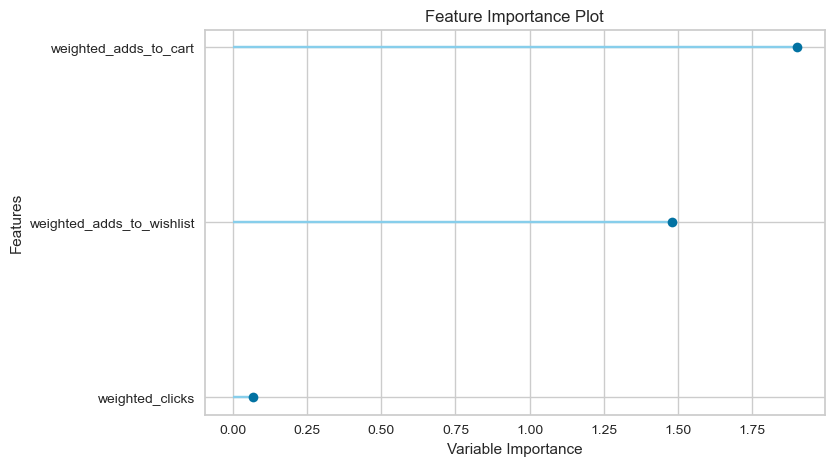

In [52]:
plot_model(hbr, plot = 'feature')

In [53]:
tuned_hbr = tune_model(hbr)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:15:41
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Huber Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0191,0.0023,0.0478,0.5139,0.0411,29.7763
1,0.0286,0.0127,0.1125,0.6625,0.0672,31.1409
2,0.0053,0.0003,0.0177,0.9588,0.0123,24.5132
3,0.0088,0.0009,0.0295,0.6259,0.0256,54.5329
4,0.0057,0.0001,0.0115,0.7433,0.0107,206.3989
5,0.0008,0.0000,0.0012,-0.7324,0.0012,20.8007
6,0.0010,0.0000,0.0033,0.6162,0.0032,66.4977
7,0.0013,0.0000,0.0035,0.7641,0.0034,17.3557
8,0.0063,0.0003,0.0172,0.5464,0.0155,30.1365


Fitting 10 folds for each of 10 candidates, totalling 100 fits


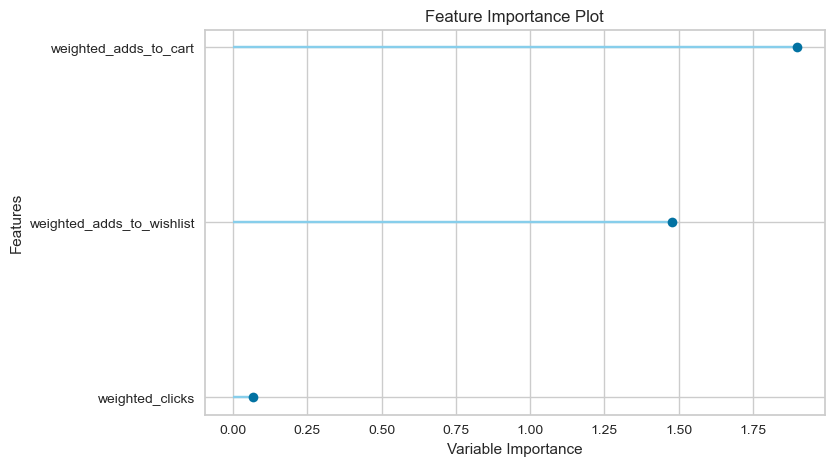

In [54]:
plot_model(tuned_hbr, plot = 'feature')

In [55]:
best = compare_models(fold=15)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:16:08
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


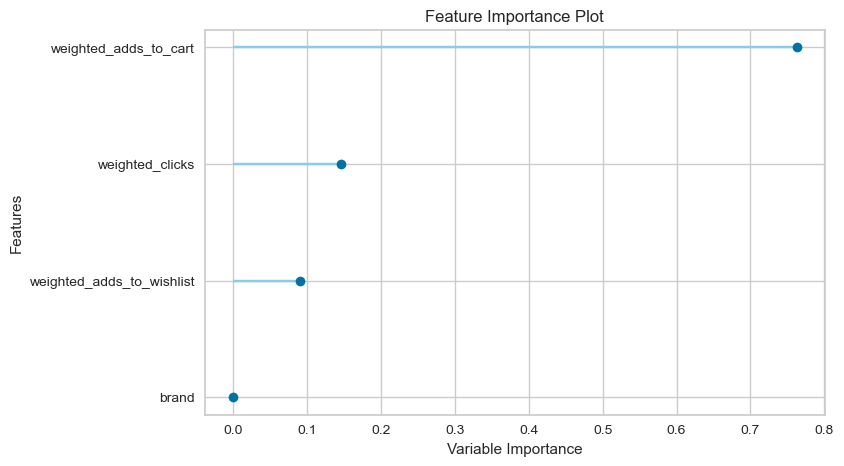

In [ ]:
plot_model(best, plot = 'feature')

In [53]:
best.coef_

array([ 1.28276633e-06, -6.65763291e-02, -1.47529143e+00,  1.89994374e+00])

In [73]:
best.get_params()

{'alpha': 0.0001,
 'epsilon': 1.35,
 'fit_intercept': True,
 'max_iter': 100,
 'tol': 1e-05,
 'warm_start': False}

## Fitting Huber Regressor

In [54]:
df_ml

,brand,weighted_clicks,weighted_adds_to_wishlist,weighted_adds_to_cart,weighted_unique_purchases,weighted_purchases
0,18.21 Man Made,1.413377e-04,1.139169e-03,5.659146e-04,0.000003,0.000002
1,23 Yards,3.267264e-06,5.244081e-05,1.114471e-04,0.000035,0.000325
2,A Fragrance Story,3.125489e-05,8.361031e-05,5.475398e-05,0.000030,0.000026
3,AL-Fakhr,1.099097e-06,1.259124e-08,1.471252e-06,0.000017,0.000015
4,AND,8.891137e-04,8.655010e-03,2.852220e-02,0.001223,0.001084
...,...,...,...,...,...,...
358,YC,7.846548e-07,3.257175e-06,8.470128e-07,0.000011,0.000010
359,Yardley London,3.042252e-07,2.059870e-07,3.292675e-06,0.000019,0.000017
360,Yves Rocher,2.229483e-03,8.660502e-04,1.058238e-02,0.003831,0.004652
361,ZM Zayn & Myza,1.762696e-04,2.630359e-04,1.908386e-04,0.000240,0.000213


In [75]:
# Train score

hbr = HuberRegressor(alpha= 0.0001,
 epsilon= 1.35,
 fit_intercept= True,
 max_iter= 100,
 tol= 1e-05,
 warm_start= False)

hbr.fit(x_train, y_train)
hbr.score(x_train, y_train)

0.7854079943840816

In [80]:
cv = RepeatedKFold(n_splits=10, random_state=123)
final_scores = cross_val_score(hbr, x_train, y_train, cv=cv, scoring='r2')
hbr_best_score = abs(final_scores).mean()

In [79]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [81]:
hbr_best_score

0.9239738040544819

In [82]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

y_preds = hbr.predict(x_test)
hbr_test_accuracy = r2_score(y_test, y_preds)
print(f"R2 score on the testing data: {hbr_test_accuracy}")

R2 score on the testing data: -17.10429025301179


In [83]:
y_preds = best.predict(x_test)
hbr_test_accuracy_pycaret = r2_score(y_test, y_preds)
print(f"R2 score on the testing data: {hbr_test_accuracy}")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- brand


In [48]:
xgb = create_model('xgboost')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:43:02
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0465,0.0044,0.0666,-0.4842,0.0570,0.9526
1,0.0559,0.0105,0.1024,-23.1700,0.0879,1.4261
2,0.0390,0.0022,0.0468,-0.0750,0.0441,0.5478
3,0.1828,0.1022,0.3197,-6.3662,0.2122,2.1221
4,0.1118,0.0373,0.1931,-0.2370,0.1556,0.5523
5,0.1197,0.0479,0.2188,0.6282,0.1301,0.6778
6,0.0787,0.0108,0.1037,0.4769,0.0876,0.5664
7,0.0243,0.0009,0.0298,-1.5496,0.0290,0.6567
8,0.0255,0.0011,0.0333,0.5791,0.0300,0.2460


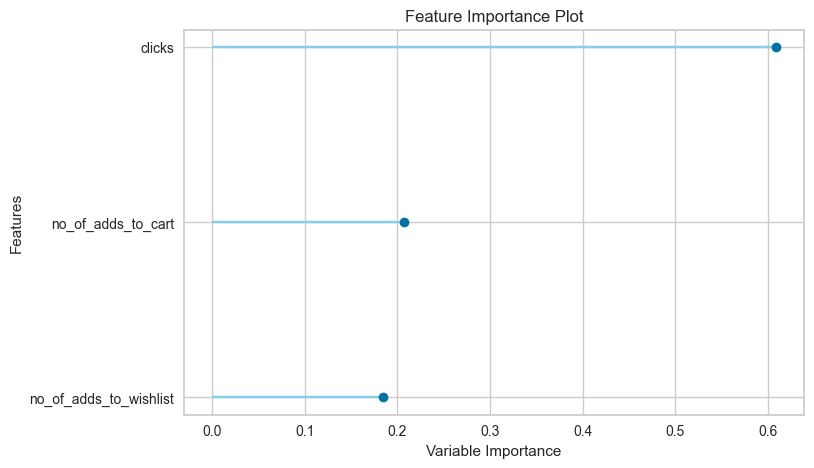

In [49]:
plot_model(xgb, plot = 'feature')

In [50]:
from sklearn.model_selection import train_test_split
import sklearn
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, StratifiedKFold
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [51]:
X = df_ml[['clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart']]
Y = df_ml['no_of_unique_purchases']

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                      test_size = 0.3, random_state = 123)

<h2>Fitting XGBRegressor with Cross Validation</h2>


In [53]:
xgb_reg = XGBRegressor(verbosity=0)
xgb_reg.fit(x_train, y_train)
train_score = xgb_reg.score(x_train, y_train)

In [54]:
train_score

0.9999489081325419

In [55]:
xgb = XGBRegressor(seed = 123)

params = { 
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7]
}


tuned_xgb = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=1, cv=5)


tuned_xgb.fit(X, Y)
print("Best parameters:", tuned_xgb.best_params_)
#print("\nLowest MAE: ", (-tuned_xgb.best_score_)**(1/2.0))
print("\nMAE: ", tuned_xgb.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

MAE:  -0.07882239644660763


In [56]:
y_preds = tuned_xgb.predict(x_test)
from sklearn.metrics import mean_absolute_error as mae
accuracy = mae(y_test, y_preds)
accuracy

0.033669832654829535

In [57]:
tuned_xgb

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_absolute_error', verbose=1)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

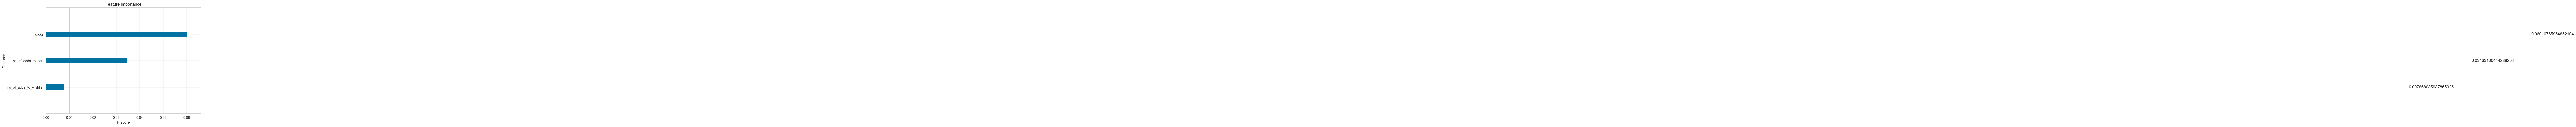

In [58]:
plot_importance(tuned_xgb.best_estimator_, importance_type='gain')

In [59]:
f_importance = tuned_xgb.best_estimator_.get_booster().get_score(importance_type='gain')

f_importance

{'clicks': 0.06010765954852104,
 'no_of_adds_to_wishlist': 0.007868085987865925,
 'no_of_adds_to_cart': 0.03463130444288254}

### Evaluating with Negative Root Mean squared error

In [122]:
cv = KFold(n_splits=10, shuffle=True, random_state=123)
final_scores = cross_val_score(xgb_reg, X, Y, cv=cv, scoring='neg_root_mean_squared_error')
abs(final_scores).mean()

0.12745060787236867

In [123]:
final_scores

array([-0.04199659, -0.10354784, -0.10756196, -0.12163532, -0.05003992,
       -0.27930523, -0.15500725, -0.21760405, -0.02240238, -0.17540554])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

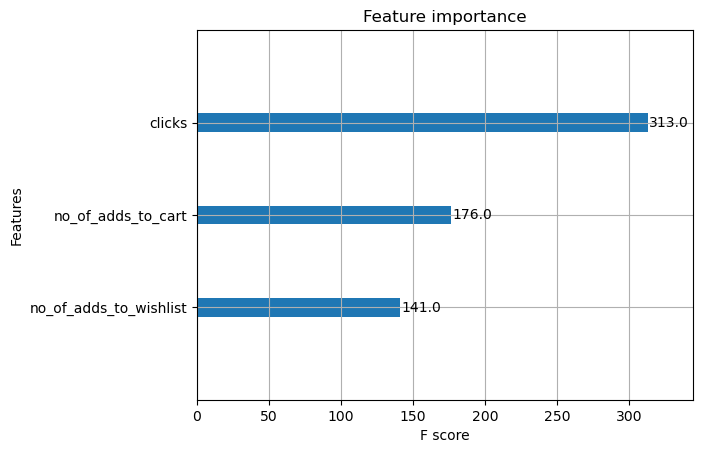

In [124]:
plot_importance(xgb_reg)

In [125]:
xgb_reg.get_booster().get_score(importance_type='weight')

{'clicks': 313.0, 'no_of_adds_to_wishlist': 141.0, 'no_of_adds_to_cart': 176.0}

### Evaluating with second method

In [126]:
xgb_reg.fit(x_train, y_train, eval_metric='rmse', eval_set=[(x_train, y_train), (x_test, y_test)], verbose=True)

[0]	validation_0-rmse:0.31431	validation_1-rmse:0.31267
[1]	validation_0-rmse:0.22676	validation_1-rmse:0.23028
[2]	validation_0-rmse:0.16602	validation_1-rmse:0.17628
[3]	validation_0-rmse:0.12244	validation_1-rmse:0.14324
[4]	validation_0-rmse:0.09135	validation_1-rmse:0.12768
[5]	validation_0-rmse:0.06951	validation_1-rmse:0.11801
[6]	validation_0-rmse:0.05518	validation_1-rmse:0.11076
[7]	validation_0-rmse:0.04387	validation_1-rmse:0.10720
[8]	validation_0-rmse:0.03621	validation_1-rmse:0.10565
[9]	validation_0-rmse:0.02957	validation_1-rmse:0.10508
[10]	validation_0-rmse:0.02536	validation_1-rmse:0.10536
[11]	validation_0-rmse:0.02194	validation_1-rmse:0.10509
[12]	validation_0-rmse:0.01933	validation_1-rmse:0.10499
[13]	validation_0-rmse:0.01728	validation_1-rmse:0.10549
[14]	validation_0-rmse:0.01567	validation_1-rmse:0.10544
[15]	validation_0-rmse:0.01377	validation_1-rmse:0.10560
[16]	validation_0-rmse:0.01272	validation_1-rmse:0.10542
[17]	validation_0-rmse:0.01187	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

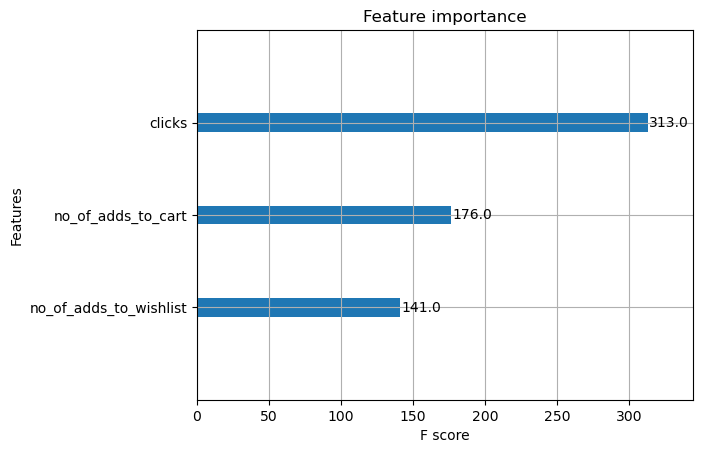

In [127]:
plot_importance(xgb_reg)

In [128]:
f_importance = xgb_reg.get_booster().get_score(importance_type='weight')

f_importance

{'clicks': 313.0, 'no_of_adds_to_wishlist': 141.0, 'no_of_adds_to_cart': 176.0}

In [129]:
importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')
importance_df.columns = ['weights']
importance_df

,weights
clicks,313.0
no_of_adds_to_wishlist,141.0
no_of_adds_to_cart,176.0


In [130]:
importance_df['weights'] = importance_df['weights']/importance_df['weights'].sum()
importance_df

,weights
clicks,0.496825
no_of_adds_to_wishlist,0.223810
no_of_adds_to_cart,0.279365


## Calculating Popularity Score based on the weights

In [131]:
df_joined_brand

,brand,clicks,price,no_of_purchases,no_of_unique_purchases,price_wishlist,no_of_adds_to_wishlist,price_cart,quantity,no_of_adds_to_cart
0,AND,29,1992.0,1.0,1,84462.0,42,187746.0,95.0,89
1,AXE,10,375.0,3.0,3,148.0,2,1089.0,6.0,6
2,Aqualogica,9,1071.0,3.0,3,718.0,3,1782.0,5.0,5
3,Arata,10,1118.0,2.0,2,919.0,1,2196.0,3.0,3
4,Babila,17,130.0,1.0,1,1082.0,4,1223.0,9.0,9
...,...,...,...,...,...,...,...,...,...,...
87,WOW SKIN SCIENCE,20,1014.0,4.0,3,1504.0,5,3821.0,14.0,12
88,Wella Professionals,23,3130.0,3.0,3,1100.0,2,4230.0,4.0,4
89,Yves Rocher,36,10300.0,6.0,4,27150.0,9,370281.0,146.0,143
90,ZM Zayn & Myza,8,339.0,1.0,1,378.0,1,2871.0,9.0,6


In [132]:
df_X = df_joined_brand[['brand', 'clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_purchases']].copy()

for column in ['clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_purchases']:
    df_X[column] = (df_X[column] - df_X[column].min()) / (df_X[column].max() - df_X[column].min())    

df_X

,brand,clicks,no_of_adds_to_wishlist,no_of_adds_to_cart,no_of_purchases
0,AND,0.061269,0.333333,0.180328,0.000000
1,AXE,0.019694,0.008130,0.010246,0.047619
2,Aqualogica,0.017505,0.016260,0.008197,0.047619
3,Arata,0.019694,0.000000,0.004098,0.023810
4,Babila,0.035011,0.024390,0.016393,0.000000
...,...,...,...,...,...
87,WOW SKIN SCIENCE,0.041575,0.032520,0.022541,0.071429
88,Wella Professionals,0.048140,0.008130,0.006148,0.047619
89,Yves Rocher,0.076586,0.065041,0.290984,0.119048
90,ZM Zayn & Myza,0.015317,0.000000,0.010246,0.000000


In [133]:
w_purchase = 0.35
w_clicks = importance_df.loc['clicks', 'weights'] * 0.65
w_wishlist = importance_df.loc['no_of_adds_to_wishlist', 'weights'] * 0.65
w_cart = importance_df.loc['no_of_adds_to_cart', 'weights'] * 0.65

w_purchase + w_clicks + w_wishlist + w_cart

1.0

In [137]:
df_popularity_fin = df_X
df_popularity_fin['popularity_score'] = (df_X['no_of_purchases'] * w_purchase + df_X['clicks'] * w_clicks + df_X['no_of_adds_to_wishlist'] * w_wishlist + df_X['no_of_adds_to_cart'] * w_cart)/(w_purchase + w_clicks + w_wishlist + w_cart)

In [138]:
df_popularity_fin.sort_values('popularity_score', ascending=False)

,brand,clicks,no_of_adds_to_wishlist,no_of_adds_to_cart,no_of_purchases,popularity_score
40,Lakme,1.000000,0.739837,0.362705,1.000000,0.846428
47,Maybelline New York,1.000000,1.000000,0.827869,0.452381,0.777077
43,M.A.C,0.903720,0.715447,1.000000,0.452381,0.735845
23,Estee Lauder,0.654267,0.845528,0.311475,0.452381,0.549184
38,L.A. Girl,0.352298,0.577236,0.985656,0.190476,0.443393
...,...,...,...,...,...,...
79,The Natural Wash,0.015317,0.000000,0.002049,0.000000,0.005319
19,Dermafique,0.008753,0.008130,0.002049,0.000000,0.004381
52,Nina Ricci,0.006565,0.008130,0.004098,0.000000,0.004047
68,Sery,0.004376,0.008130,0.002049,0.000000,0.002968
